In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System and file handling
import os

# Text processing
import re
from collections import Counter

In [2]:
# Load the Excel data
excel_file_path = "./CIRPASS-DPP-related-Initiatives-Dataset-2024-May-17/Results_initatives_questionnaire_for_publication_17-05-2024.xlsx"
df = pd.read_excel(excel_file_path)

# Display basic information about the data
print("Dataframe Shape:", df.shape)
print("Columns:", df.columns)
df.head()

In [3]:
# Basic statistics and information
print(df.info())  # Column types and non-null counts

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Display columns with missing values
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("Missing Values Overview:")
print(missing_data[missing_data['Missing Values'] > 0])

In [5]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

In [6]:
# Display data types and unique values for each column
print("Column Data Types and Unique Values:")
for column in df.columns:
    print(f"{column}: {df[column].dtype}, Unique Values: {df[column].nunique()}")

In [7]:
# Summary for numerical columns
numerical_summary = df.describe()
print("Numerical Summary:")
print(numerical_summary)

# Summary for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"{column} - Unique Categories:")
    print(df[column].value_counts().head(10))  # Display top 10 most frequent values

## Pre-Processing

In [8]:
# Select the relevant columns
relevant_columns = [
    "Initiative name", "Initiative short name",
    "Goal / USP / Benefit", "Host organization type", "Solution type", "Sector",
    "Potential for cross-sectors application ?", "Focus on final product or supply chain exchange",
    "Market scope", "Current market penetration", "Technology readiness", "Business model",
    "Target group (e.g. data/platform user)",

    "Product traceability", "Functional and technical specifications",
    "Product material composition information", "Product design & service information",
    "Product usage data", "Product repair data", "Recycling data",
    "Circularity info & label (for consumer)",

    "Product ID: type", "Product ID: granularity", "Type",
    "Machine readable data carrier", "Resolver",

    "ID minting", "Data storage location", "Data transport openness level",
    "Data packaging", "Level", "if advanced",

    "Data use management", "Evidence", "Convenience", "Data protection",
    "Traceability"
]

# Create a working copy with only the relevant columns
df_cleaned = df[relevant_columns].copy()

# Display the shape of the cleaned DataFrame
print("Cleaned DataFrame Shape:", df_cleaned.shape)

In [9]:
# Check for missing values in the cleaned DataFrame
missing_values = df_cleaned.isnull().sum().sort_values(ascending=False)
print("Missing Values Overview (Cleaned DataFrame):")
print(missing_values[missing_values > 0])

In [10]:
# Handle missing values for critical columns (imputation with placeholder)
critical_columns = [
    "Goal / USP / Benefit", "Solution type", "Sector", "Host organization type"
]

# Fill missing values in critical columns with "Unknown"
df_cleaned[critical_columns] = df_cleaned[critical_columns].fillna("Unknown")

# Dynamically identify moderate columns
moderate_missing_cols = [
    col for col in df_cleaned.columns
    if col not in critical_columns and df_cleaned[col].isnull().mean() > 0
]

# Impute moderate columns with appropriate logic
for col in moderate_missing_cols:
    if df_cleaned[col].dtype == "object":  # For categorical/text columns
        df_cleaned[col] = df_cleaned[col].fillna("Unknown")
    else:  # For numerical columns
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Verify if all missing values have been resolved
remaining_missing = df_cleaned.isnull().sum().sort_values(ascending=False)
print("Remaining Missing Values (Post-Cleanup):")
print(remaining_missing[remaining_missing > 0])

In [11]:
df_cleaned.head()

In [12]:
# Define a dictionary with the current column names as keys and the new column names as values
new_column_names = {
  "Initiative name": "Initiative_Name",
  "Initiative short name": "Initiative_Short_Name",
  "Goal / USP / Benefit": "Goal_USP_Benefit",
  "Host organization type": "Host_Organization_Type",
  "Solution type": "Solution_Type",
  "Sector": "Sector",
  "Potential for cross-sectors application ?": "Potential_Cross_Sector",
  "Focus on final product or supply chain exchange": "Focus_Final_Product_Supply_Chain",
  "Market scope": "Market_Scope",
  "Current market penetration": "Current_Market_Penetration",
  "Technology readiness": "Technology_Readiness",
  "Business model": "Business_Model",
  "Target group (e.g. data/platform user)": "Target_Group",
  "Product traceability": "Product_Traceability",
  "Functional and technical specifications": "Functional_Technical_Specifications",
  "Product material composition information": "Product_Material_Composition",
  "Product design & service information": "Product_Design_Service",
  "Product usage data": "Product_Usage_Data",
  "Product repair data": "Product_Repair_Data",
  "Recycling data": "Recycling_Data",
  "Circularity info & label (for consumer)": "Circularity_Info_Label",
  "Product ID: type": "Product_ID_Type",
  "Product ID: granularity": "Product_ID_Granularity",
  "Type": "Identifier_Type",
  "Machine readable data carrier": "Machine_Readable_Data_Carrier",
  "Resolver": "Resolver",
  "ID minting": "ID_Minting",
  "Data storage location": "Data_Storage_Location",
  "Data transport openness level": "Data_Transport_Openness_Level",
  "Data packaging": "Data_Packaging",
  "Level": "Level",
  "if advanced": "If_Advanced",
  "Data use management": "Data_Use_Management",
  "Evidence": "Evidence",
  "Convenience": "Convenience",
  "Data protection": "Data_Protection",
  "Traceability": "Traceability"
}

# Rename the columns
df_cleaned.rename(columns=new_column_names, inplace=True)

# Display the updated DataFrame
df_cleaned.head()

In [13]:
def clean_text(text):
    """
    Cleans a string by:
      - Removing unwanted non-alphanumeric chars (except spaces & commas).
      - Replacing multiple spaces with a single space.
      - Lowercasing and stripping.
    """
    if isinstance(text, str):
        text = re.sub(r"[^a-zA-Z0-9\s,]", "", text)  # keep alphanumerics, spaces, commas
        text = re.sub(r"\s+", " ", text)            # collapse multiple spaces
        return text.strip().lower()
    return text


def normalize_and_split(series):
    """
    For a given Series, splits string cells on commas into a list of items.
    Returns the transformed Series where each row is now a list of strings.
    """
    return series.apply(
        lambda x: [item.strip().lower() for item in x.split(",")] if isinstance(x, str) else []
    )

def normalize_and_split_smart(column):
    """
    Normalize and split multi-value columns, preserving text inside parentheses.
    Ensures results are lower-case and stripped of extra whitespace.
    Args:
        column: Pandas Series to process.
    """
    def split_preserve_parentheses(value):
        if isinstance(value, str):
            # Find all protected matches (parentheses)
            protected = re.findall(r'\(.*?\)', value)
            # Create a placeholder map
            placeholder_map = {f"__PARENTHESIS_{idx}__": text for idx, text in enumerate(protected)}
            
            # Replace protected text with placeholders
            for placeholder, text in placeholder_map.items():
                value = value.replace(text, placeholder)
            
            # Split on commas outside parentheses
            parts = [item.strip() for item in value.split(",")]
            
            # Restore placeholders back to their original text
            restored_parts = []
            for part in parts:
                for placeholder, text in placeholder_map.items():
                    part = part.replace(placeholder, text)
                restored_parts.append(part)
            
            # Finally, convert all parts to lowercase
            return [part.lower() for part in restored_parts]
        return []
    
    return column.apply(split_preserve_parentheses)

def standardize_values(values, replacements):
    """
    For a list of items:
      - If an item appears in 'replacements' dict, map it directly.
      - Otherwise keep it as is.
    Returns the updated list (or the original value if not a list).
    """
    if not isinstance(values, list):
        return values  # e.g., if it's not a list, return as is

    return [replacements.get(val, val) for val in values]


def apply_partial_match(values, partial_rules):
    """
    For a list of items, do partial (keyword) matching per 'partial_rules'.
    'partial_rules' is a list of (keyword, label) pairs, e.g.:
      partial_rules = [
         ("cross", "cross-sector"),
         ("electron", "electronics"),
         ("textile", "textile"),
      ]
    If the item contains the keyword (case-insensitive), we unify to label.
    If multiple keywords match, the first match in partial_rules takes precedence.
    """
    if not isinstance(values, list):
        return values

    new_list = []
    for val in values:
        v_lower = val.lower()
        replaced = False
        for keyword, label in partial_rules:
            if keyword in v_lower:
                new_list.append(label)
                replaced = True
                break
        if not replaced:
            new_list.append(val)
    return new_list

def apply_partial_match_str(text, partial_rules):
    """
    For a single string 'text', check each (keyword, label) in partial_rules.
    Match keywords as whole words using regex. If no match, return original text.
    """
    if not isinstance(text, str):
        return text

    for keyword, label in partial_rules:
        # Match as whole word (e.g., "national" won't match "international")
        if re.search(rf'\b{keyword}\b', text.lower()):
            return label
    return text  # No matches => return original

In [14]:
# Define free-text columns
free_text_columns = ["Goal_USP_Benefit"]

# Apply text cleaning
df_cleaned[free_text_columns] = df_cleaned[free_text_columns].map(clean_text)

In [15]:
# Define multi-value columns
multi_value_columns = ["Sector", "Solution_Type", "Host_Organization_Type", "Technology_Readiness",
                       "Target_Group", "Product_Traceability", "Product_Material_Composition", 
                       "Product_Design_Service", "Product_Usage_Data", "Product_Repair_Data", "Recycling_Data",
                       "Circularity_Info_Label", "Product_ID_Type", "Product_ID_Granularity", "Identifier_Type", "Traceability"]

# Normalize and split multi-value columns
for col in multi_value_columns:
    df_cleaned[col] = normalize_and_split_smart(df_cleaned[col])

In [16]:
# Define replacements for standardizing values
replacements = {
    "cross-sector (more than one)": "cross-sector",
    "cross-sector (more then one)": "cross-sector",
    "cross-sector": "cross-sector",
}

# Apply replacements to standardize values
df_cleaned["Sector"] = df_cleaned["Sector"].apply(
    lambda x: standardize_values(x, replacements)
)

In [17]:
partial_rules = [
    ("all of the above", "combination"),
    ("combination", "combination"),
    ("platform", "platform"),
    ("traceability", "traceability solution"),
    ("data scheme", "product data scheme"),
    ("standard", "standard"),
    ("others", "others"),
]

df_cleaned["Solution_Type"] = df_cleaned["Solution_Type"].apply(
    lambda x: apply_partial_match(x, partial_rules)
)

In [18]:
partial_rules = [
    ("regional", "Regional"),
    ("national", "National"),
]

df_cleaned["Market_Scope"] = df_cleaned["Market_Scope"].apply(
    lambda x: apply_partial_match_str(x, partial_rules)
)

In [19]:
# Add count columns for multi-value fields
for col in multi_value_columns:
    df_cleaned[f"{col}_count"] = df_cleaned[col].apply(len)

In [20]:
# Normalize binary columns
binary_columns = [
    "Potential_Cross_Sector", 
    "Machine_Readable_Data_Carrier",
    "Resolver"
]
df_cleaned[binary_columns] = df_cleaned[binary_columns].applymap(
    lambda x: "yes" if str(x).strip().lower() in ["yes", "y", "true", "1"] 
    else "no" if str(x).strip().lower() in ["no", "n", "false", "0"] 
    else "unknown"
)

In [21]:
# Verify the final structure of the dataset
# df_cleaned.info()
df_cleaned.head()

In [22]:
# df_cleaned.to_csv("df_cleaned.csv", index=False)

## Data Analysis

In [23]:
from matplotlib.colors import LinearSegmentedColormap, to_rgba, to_hex
import matplotlib.patheffects as PathEffects
import colorsys

# Define thesis color palette
thesis_colors = {
    'dark_blue': '#050A44',
    'bright_blue': '#0A21C0',
    'light_grey': '#B3B4BD',
    'dark_grey': '#2C2E3A'
}

# Create color sequences for different visualization needs
primary_palette = [thesis_colors['dark_blue'], thesis_colors['bright_blue'], 
                   thesis_colors['light_grey'], thesis_colors['dark_grey']]

# Create an extended palette by adding some variations
extended_palette = []
for color in primary_palette:
    extended_palette.append(color)
    
    # Add lighter variant
    r, g, b, _ = to_rgba(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    lighter_l = min(1.0, l * 1.3)
    lighter_rgb = colorsys.hls_to_rgb(h, lighter_l, s)
    extended_palette.append(to_hex(lighter_rgb))

# Set up matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(primary_palette)

# Set figure aesthetics
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14


# Create a vibrant palette derived from your thesis colors but more colorful
def create_colorful_palette(base_colors, n_colors=10):
    """Create a more vibrant colorful palette while maintaining thesis identity"""
    colorful = []
    
    # Start with the bright blue as it's the most vibrant
    base = thesis_colors['bright_blue']
    r, g, b, _ = to_rgba(base)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Create a range of hues while maintaining connection to original color
    for i in range(n_colors):
        # Shift the hue around the color wheel but maintain saturation profile
        new_h = (h + 0.1 * i) % 1.0
        # Vary the lightness to create contrast
        new_l = min(0.8, max(0.3, l + 0.1 * (i % 3 - 1)))
        # Keep saturation high for vibrant colors
        new_s = min(1.0, s * 1.2)
        
        new_rgb = colorsys.hls_to_rgb(new_h, new_l, new_s)
        new_hex = to_hex(new_rgb)
        colorful.append(new_hex)
    
    # Ensure the original bright blue is included
    if thesis_colors['bright_blue'] not in colorful:
        colorful[0] = thesis_colors['bright_blue']
    
    # Add dark blue as an accent
    if len(colorful) > 5:
        colorful[5] = thesis_colors['dark_blue']
    
    return colorful

# Create a colorful palette for pie charts and other visualizations
thesis_colorful = create_colorful_palette(primary_palette, 12)

# Function to get appropriate palette based on chart type
def get_thesis_colors(chart_type='default', n_colors=None):
    """
    Get appropriate colors based on chart type
    
    Args:
        chart_type: 'default', 'pie', 'colorful', or 'monochrome'
        n_colors: Number of colors needed
    
    Returns:
        List of colors appropriate for the visualization
    """
    if n_colors is None:
        n_colors = 10
        
    if chart_type == 'pie' or chart_type == 'colorful':
        return thesis_colorful[:n_colors]
    elif chart_type == 'monochrome':
        # Create a monochrome palette based on bright blue
        r, g, b, _ = to_rgba(thesis_colors['bright_blue'])
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        monochrome = []
        for i in range(n_colors):
            new_l = 0.8 - (i * 0.7 / n_colors)
            new_rgb = colorsys.hls_to_rgb(h, new_l, s)
            monochrome.append(to_hex(new_rgb))
        return monochrome
    else:
        # Default - use extended palette
        return extended_palette[:n_colors]

# Display the defined color palette
print("Thesis Color Palette:")
for name, color in thesis_colors.items():
    print(f"- {name}: {color}")

# Preview the palette in a small plot (optional)
plt.figure(figsize=(8, 1))
for i, color in enumerate(primary_palette):
    plt.axvspan(i, i+1, color=color)
plt.title("Thesis Primary Color Palette")
plt.axis('off')
plt.show()

In [24]:
# Plot stylized Pie Charts
def plot_pie(data, title, figsize=(10, 8)):
    """
    Plot a pie chart with thesis colors.
    """
    plt.figure(figsize=figsize)
    
    # Create the pie chart with white text and larger font size
    wedges, texts, autotexts = plt.pie(
        data,
        labels=None,  # No labels - will use legend instead
        autopct='%1.1f%%',
        startangle=140,
        colors=get_thesis_colors('pie', len(data)),
        shadow=False,
        explode=[0.05] * len(data),  # Slight explosion for all slices
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}  # White edge around slices
    )
    
    # Make the percentage text white with a dark outline and larger
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
        autotext.set_path_effects([
            PathEffects.withStroke(linewidth=3, foreground='black')
        ])
    
    plt.title(title, fontsize=16)
    plt.ylabel("")
    plt.legend(data.index, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [25]:
# Plot stylized Bar Charts
def plot_bar(data, title, xlabel="Count", ylabel=None, figsize=(10, 6), horizontal=True, color=None):
    """
    Plot a styled bar chart with thesis colors.
    
    Parameters:
        data: Series to plot
        title: Chart title
        xlabel: X-axis label
        ylabel: Y-axis label
        figsize: Figure size as tuple (width, height)
        horizontal: If True, creates a horizontal bar chart
        color: Optional color override
    """
    plt.figure(figsize=figsize)
    
    # Determine chart type
    kind = 'barh' if horizontal else 'bar'
    
    # Set default color if not provided
    if color is None:
        color = thesis_colors['bright_blue']
    
    # Create the plot
    ax = data.plot(
        kind=kind,
        color=color,
        edgecolor='white',
        linewidth=0.8
    )
    
    # Add title and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel if ylabel else data.name)
    
    # Add value labels to the bars
    for i, v in enumerate(data):
        if horizontal:
            ax.text(v + 0.1, i, str(v), va='center')
        else:
            ax.text(i, v + 0.1, str(v), ha='center')
    
    # Apply grid styling
    ax.grid(axis='x' if horizontal else 'y', linestyle='--', alpha=0.7, color=thesis_colors['light_grey'])
    
    plt.tight_layout()
    plt.show()

In [26]:
# Plot stylized Heatmaps
def plot_heatmap(data, title, figsize=(12, 8), annot=True, cmap=None, fmt=".0f"):
    """
    Plot a styled heatmap using thesis colors.
    
    Parameters:
        data: DataFrame containing the heatmap data
        title: Chart title
        figsize: Figure size as tuple (width, height)
        annot: If True, write the data value in each cell
        cmap: Colormap to use (defaults to thesis blue colormap)
        fmt: String formatting code for annotations
    """
    plt.figure(figsize=figsize)
    
    # Create a thesis-themed colormap if not provided
    if cmap is None:
        cmap = LinearSegmentedColormap.from_list(
            'thesis_blues', 
            ['white', thesis_colors['light_grey'], thesis_colors['bright_blue'], thesis_colors['dark_blue']]
        )
    
    # Create the heatmap
    sns.heatmap(
        data, 
        cmap=cmap, 
        annot=annot, 
        fmt=fmt, 
        linewidths=0.5,
        cbar_kws={'label': 'Count'}
    )
    
    # Style the plot
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

In [27]:

# Plot stylized Line Charts
def plot_line(data, title, xlabel=None, ylabel=None, figsize=(10, 6), 
             marker='o', color=None, legend_loc='best'):
    """
    Plot a styled line chart with thesis colors.
    
    Parameters:
        data: Series or DataFrame to plot
        title: Chart title
        xlabel: X-axis label
        ylabel: Y-axis label
        figsize: Figure size as tuple (width, height)
        marker: Point marker style
        color: Line color(s) (defaults to thesis colors)
        legend_loc: Legend location if multiple lines
    """
    plt.figure(figsize=figsize)
    
    # Set default color if not provided and it's a Series
    if color is None:
        if isinstance(data, pd.Series):
            color = thesis_colors['bright_blue']
        else:
            color = get_thesis_colors('default', len(data.columns))
    
    # Create the line plot
    ax = data.plot(
        kind='line',
        marker=marker,
        color=color,
        linewidth=2.5,
        markersize=8,
        markeredgecolor='white',
        markeredgewidth=1
    )
    
    # Add title and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel if xlabel else "X")
    plt.ylabel(ylabel if ylabel else (data.name if isinstance(data, pd.Series) else "Y"))
    
    # Style the legend if it's a DataFrame
    if isinstance(data, pd.DataFrame) and len(data.columns) > 1:
        plt.legend(loc=legend_loc, frameon=True, framealpha=0.9, facecolor='white')
    
    # Apply grid styling
    ax.grid(linestyle='--', alpha=0.3, color=thesis_colors['light_grey'])
    
    plt.tight_layout()
    plt.show()

In [28]:
# Plot stylized Multi-Bar Charts (grouped or stacked)
def plot_multi_bar(data, title, xlabel="Categories", ylabel="Count", figsize=(12, 6), 
                  stacked=False, horizontal=False):
    """
    Plot a grouped or stacked bar chart for multiple series.
    
    Parameters:
        data: DataFrame with categories as index and columns as series
        title: Chart title
        xlabel: X-axis label
        ylabel: Y-axis label
        figsize: Figure size as tuple (width, height)
        stacked: If True, creates a stacked bar chart
        horizontal: If True, creates horizontal bars
    """
    plt.figure(figsize=figsize)
    
    # Determine chart type
    kind = 'barh' if horizontal else 'bar'
    
    # Create the plot with thesis colors
    ax = data.plot(
        kind=kind,
        stacked=stacked,
        color=get_thesis_colors('colorful', len(data.columns)),
        edgecolor='white',
        linewidth=0.8
    )
    
    # Add title and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Style the legend
    plt.legend(loc='best', frameon=True, framealpha=0.9, facecolor='white')
    
    # Apply grid styling
    ax.grid(axis='x' if horizontal else 'y', linestyle='--', alpha=0.7, 
            color=thesis_colors['light_grey'])
    
    plt.tight_layout()
    plt.show()

In [29]:
# Plot initiatives by Market Scope
df_exploded = df_cleaned.explode('Market_Scope')

# Check frequency
counts = df_exploded['Market_Scope'].value_counts(dropna=False)
print(counts)

# Plot the Market Scope of Initiatives
plot_pie(counts, "Market Scope of Initiatives")
plot_bar(counts, "Market Scope of Initiatives")

In [30]:
df_exploded = df_cleaned.explode('Technology_Readiness')

# Check frequency
counts = df_exploded['Technology_Readiness'].value_counts(dropna=False)
print(counts)

# Plot the Technology Readiness of Initiatives
plot_pie(counts, "Technology Readiness of Initiatives")
plot_bar(counts, "Technology Readiness of Initiatives")

In [31]:
df_exploded = df_cleaned.explode('Solution_Type')

# Check frequency
counts = df_exploded['Solution_Type'].value_counts(dropna=False)
df_exploded['Solution_Type'] = df_exploded['Solution_Type'].apply(lambda x: 'others' if x in counts[counts == 1].index else x)
final_counts = df_exploded['Solution_Type'].value_counts(dropna=False)
print(final_counts)

# Plot the Solution Type of Initiatives
plot_bar(final_counts, "Solution Type of Initiatives")

In [32]:
df_exploded = df_cleaned.explode('Sector')

# Check frequency
counts = df_exploded['Sector'].value_counts(dropna=False)
df_exploded['Sector'] = df_exploded['Sector'].apply(lambda x: 'others' if x in counts[counts == 1].index else x)
final_counts = df_exploded['Sector'].value_counts(dropna=False)
print(final_counts)

# Plot the Sector of Initiatives
plot_pie(final_counts, "Sector of Initiatives")
plot_bar(final_counts, "Sector of Initiatives")

In [33]:
df_exploded = df_cleaned.explode('Host_Organization_Type')

# Check frequency
counts = df_exploded['Host_Organization_Type'].value_counts(dropna=False)
print(counts)

# Plot the Host Organization Type of Initiatives
plot_bar(counts, "Host Organization Type of Initiatives")

In [34]:
df_exploded = df_cleaned.explode('Focus_Final_Product_Supply_Chain')

# Check frequency
counts = df_exploded['Focus_Final_Product_Supply_Chain'].value_counts(dropna=False)
print(counts)

# Plot the Focus on Final Product or Supply Chain Exchange of Initiatives
plot_bar(counts, "Focus on Final Product or Supply Chain Exchange of Initiatives")

In [35]:
df_exploded = df_cleaned.explode('Current_Market_Penetration')

# Check frequency
counts = df_exploded['Current_Market_Penetration'].value_counts(dropna=False)
print(counts)

# Plot the Current Market Penetration of Initiatives
plot_bar(counts, "Current Market Penetration of Initiatives")

In [36]:
df_exploded = df_cleaned.explode('Business_Model')

# Check frequency
counts = df_exploded['Business_Model'].value_counts(dropna=False)
print(counts)

# Plot the Business Model of Initiatives
plot_bar(counts, "Business Model of Initiatives")

In [37]:
df_exploded = df_cleaned.explode('Target_Group')

# Check frequency
counts = df_exploded['Target_Group'].value_counts(dropna=False)
df_exploded['Target_Group'] = df_exploded['Target_Group'].apply(lambda x: 'others' if x in counts[counts == 1].index else x)
final_counts = df_exploded['Target_Group'].value_counts(dropna=False)
print(final_counts)

# Plot the Target Group of Initiatives
plot_bar(final_counts, "Target Group of Initiatives")

In [38]:
df_exploded = df_cleaned.explode('Product_Traceability')

# Check frequency
counts = df_exploded['Product_Traceability'].value_counts(dropna=False)
print(counts)

# Plot the Product Traceability of Initiatives
plot_bar(counts, "Product Traceability of Initiatives")

In [39]:
df_exploded = df_cleaned.explode('Identifier_Type')

# Check frequency
counts = df_exploded['Identifier_Type'].value_counts(dropna=False)
print(counts)

# Plot the Identifier Type of Initiatives
plot_bar(counts, "Identifier Type of Initiatives")

In [40]:

df_exploded = df_cleaned.explode('ID_Minting')

# Check frequency
counts = df_exploded['ID_Minting'].value_counts(dropna=False)
print(counts)

# Plot the ID Minting of Initiatives
plot_pie(counts, "ID Minting of Initiatives")
plot_bar(counts, "ID Minting of Initiatives")

In [41]:

df_exploded = df_cleaned.explode('Data_Storage_Location')

# Check frequency
counts = df_exploded['Data_Storage_Location'].value_counts(dropna=False)
print(counts)

# Plot the Data Storage Location of Initiatives
plot_pie(counts, "Data Storage Location of Initiatives")
plot_bar(counts, "Data Storage Location of Initiatives")

In [42]:

df_exploded = df_cleaned.explode('Data_Packaging')

# Check frequency
counts = df_exploded['Data_Packaging'].value_counts(dropna=False)
print(counts)

# Plot the Data Packaging of Initiatives
plot_bar(counts, "Data Packaging of Initiatives")

In [43]:
def plot_filtered_heatmap(df, col1, col2):
    """
    Creates a heatmap showing the relationship between two categorical variables,
    filtering both columns by replacing single-occurrence values with 'others'.

    Steps:
    - Compute value counts BEFORE exploding
    - Replace low-frequency categories with 'others'
    - Explode both columns
    - Generate cross-tabulation
    - Plot heatmap
    """
    df_temp = df_cleaned.copy()

    # Compute initial value counts BEFORE exploding
    counts_col1 = df_temp[col1].explode().value_counts()
    counts_col2 = df_temp[col2].explode().value_counts()

    # Replace single-occurrence values with 'others' BEFORE exploding
    df_temp[col1] = df_temp[col1].apply(lambda x: [v if counts_col1.get(v, 0) > 1 else 'others' for v in x] if isinstance(x, list) else x)
    df_temp[col2] = df_temp[col2].apply(lambda x: [v if counts_col2.get(v, 0) > 1 else 'others' for v in x] if isinstance(x, list) else x)

    # Explode both columns
    df_temp = df_temp.explode(col1).explode(col2)

    # Generate cross-tabulation
    heatmap_data = pd.crosstab(df_temp[col1], df_temp[col2])

    # Plot the heatmap
    plot_heatmap(heatmap_data, f"Heatmap of {col1} vs. {col2}")

In [44]:
plot_filtered_heatmap(df_cleaned, 'Sector', 'Solution_Type')

In [45]:
plot_filtered_heatmap(df_cleaned, 'Market_Scope', 'Technology_Readiness')

In [46]:
plot_filtered_heatmap(df_cleaned, 'Identifier_Type', 'Data_Storage_Location')

In [47]:
plot_filtered_heatmap(df_cleaned, 'ID_Minting', 'Data_Storage_Location')

In [48]:
plot_filtered_heatmap(df_cleaned, 'Target_Group', 'Sector')

In [49]:
# Analyze the relationship between identifier technology choices and machine readable carriers
plot_filtered_heatmap(df_cleaned, 'Identifier_Type', 'Machine_Readable_Data_Carrier')

In [50]:
# For Resolver usage and Identifier_Type
plot_filtered_heatmap(df_cleaned, 'Resolver', 'Identifier_Type')

In [51]:
# Now examine product granularity by storage location
plot_filtered_heatmap(df_cleaned, 'Product_ID_Granularity', 'Data_Storage_Location')


Text heavy:
Goal_USP_Benefit,
Traceability,
Data_Protection,
Evidence,
Convenience,
Data_Transport_Openness_Level

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Preprocess text
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
doc_term_matrix = vectorizer.fit_transform(df_cleaned['Goal_USP_Benefit'].dropna())

# Perform LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Display topics
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

In [54]:
# Basic word frequency analysis across all initiatives
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK resources (run once)
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

# Define custom stopwords for DPP domain
stop_words = set(stopwords.words('english'))
custom_stop_words = {
    'digital', 'product', 'passport', 'dpp', 'data', 'solution', 
    'platform', 'unknown', 'information', 'provide', 'based',
    'can', 'products', 'across', 'will', 'also', 'use', 'using'
}
all_stop_words = stop_words.union(custom_stop_words)

def extract_key_terms(text, min_length=3):
    if not isinstance(text, str):
        return []
    # Tokenize and filter
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens 
                      if word.isalpha() 
                      and word not in all_stop_words 
                      and len(word) >= min_length]
    return filtered_tokens

# Extract terms from all goal statements
all_terms = []
for goal in df_cleaned['Goal_USP_Benefit'].dropna():
    all_terms.extend(extract_key_terms(goal))

# Count term frequencies
term_counts = Counter(all_terms)
top_terms = pd.Series(dict(term_counts.most_common(20)))
top_terms.name = "Term Frequency"

# Use your existing plot_bar function for consistent styling
plot_bar(
    top_terms.sort_values(),
    "Top Terms in Initiative Goal Statements", 
    xlabel="Frequency", 
    ylabel="Terms", 
    horizontal=True,
    figsize=(12, 8)
)

In [55]:
# Analyze bigrams (word pairs) to understand context better
from nltk import bigrams

def extract_bigrams(text):
    if not isinstance(text, str):
        return []
    
    # Tokenize and clean
    tokens = nltk.word_tokenize(text.lower())
    # Keep only alphabetic tokens not in stopwords
    filtered_tokens = [word for word in tokens 
                      if word.isalpha() and word not in all_stop_words]
    
    # Generate bigrams
    bi_grams = list(bigrams(filtered_tokens))
    return bi_grams

# Extract all bigrams
all_bigrams = []
for goal in df_cleaned['Goal_USP_Benefit'].dropna():
    all_bigrams.extend(extract_bigrams(goal))

# Count bigram frequencies
bigram_counts = Counter(all_bigrams)
top_bigrams = dict(bigram_counts.most_common(20))

# Convert to readable format and create Series
readable_bigrams = {f"{bi[0]} {bi[1]}": count for bi, count in top_bigrams.items()}
bigram_series = pd.Series(readable_bigrams)
bigram_series.name = "Frequency"

# Use your existing plot_bar function for consistent styling
plot_bar(
    bigram_series.sort_values(),
    "Most Common Word Pairs in Initiative Goal Statements",
    xlabel="Frequency",
    ylabel="Word Pairs",
    horizontal=True,
    figsize=(12, 8)
)

In [56]:
# Compare key terms across top sectors in a single visualization
top_sectors = df_cleaned.explode('Sector')['Sector'].value_counts().head(3).index.tolist()

# Create a dictionary to store term frequencies by sector
sector_term_data = {}

# For each sector, analyze and collect the top terms
for sector in top_sectors:
    # Get initiatives in this sector
    sector_initiatives = df_cleaned[df_cleaned['Sector'].apply(
        lambda x: sector in x if isinstance(x, list) else False)]
    
    # Extract all terms from this sector's goal statements
    sector_terms = []
    for goal in sector_initiatives['Goal_USP_Benefit'].dropna():
        sector_terms.extend(extract_key_terms(goal))
    
    # Count term frequencies
    term_counts = Counter(sector_terms)
    # Store the top terms for this sector
    sector_term_data[sector] = dict(term_counts.most_common(10))

# Convert the dictionary to a DataFrame for visualization
# First, get a unique set of all top terms across all sectors
all_top_terms = set()
for sector_terms in sector_term_data.values():
    all_top_terms.update(sector_terms.keys())

# Convert set to list before creating DataFrame
all_top_terms_list = list(all_top_terms)

# Create a DataFrame with terms as index and sectors as columns
term_comparison_df = pd.DataFrame(index=all_top_terms_list, columns=top_sectors)

# Fill the DataFrame with frequency values
for sector, terms in sector_term_data.items():
    for term, freq in terms.items():
        term_comparison_df.loc[term, sector] = freq

# Fill NaN values with 0 (terms not present in a sector)
term_comparison_df = term_comparison_df.fillna(0)

# Sort by the sum of frequencies across all sectors
term_comparison_df['total'] = term_comparison_df.sum(axis=1)
term_comparison_df = term_comparison_df.sort_values('total', ascending=True).drop('total', axis=1)

# Take the top 15 terms for readability
term_comparison_df = term_comparison_df.tail(15)

# Use your custom plot_multi_bar function
plot_multi_bar(
    term_comparison_df,
    "Comparison of Top Terms Across Major Sectors",
    xlabel="Frequency",
    ylabel="Terms",
    figsize=(12, 10),
    stacked=True,
    horizontal=True
)

In [57]:
# Analyze terminology variations across technology readiness levels
# First, get the top Technology_Readiness categories
tech_ready_categories = df_cleaned.explode('Technology_Readiness')['Technology_Readiness'].value_counts().head(3).index.tolist()

# Create a dictionary to store term frequencies by technology readiness level
tech_term_data = {}

# For each tech readiness level, analyze and collect the top terms
for tech_level in tech_ready_categories:
    # Get initiatives at this tech readiness level
    tech_initiatives = df_cleaned[df_cleaned['Technology_Readiness'].apply(
        lambda x: tech_level in x if isinstance(x, list) else False)]
    
    # Extract all terms from the goal statements at this level
    tech_terms = []
    for goal in tech_initiatives['Goal_USP_Benefit'].dropna():
        tech_terms.extend(extract_key_terms(goal))
    
    # Count term frequencies
    term_counts = Counter(tech_terms)
    # Store the top terms for this tech level
    tech_term_data[tech_level] = dict(term_counts.most_common(15))

# Convert to DataFrame for visualization
all_top_terms = set()
for terms in tech_term_data.values():
    all_top_terms.update(terms.keys())

# Create DataFrame with terms as index and tech levels as columns
term_tech_df = pd.DataFrame(index=list(all_top_terms), columns=tech_ready_categories)

# Fill the DataFrame with frequency values
for tech, terms in tech_term_data.items():
    for term, freq in terms.items():
        term_tech_df.loc[term, tech] = freq

# Fill NaN values with 0
term_tech_df = term_tech_df.fillna(0)

# Sort by total frequency
term_tech_df['total'] = term_tech_df.sum(axis=1)
term_tech_df = term_tech_df.sort_values('total', ascending=False).drop('total', axis=1)

# Take the top 20 terms
term_tech_df = term_tech_df.head(20)

# Use your existing plot_multi_bar function for consistent styling
plot_multi_bar(
    term_tech_df,
    "Terminology Used Across Technology Readiness Levels",
    xlabel="Frequency",
    ylabel="Terms",
    figsize=(14, 10),
    stacked=True,
    horizontal=True
)

In [58]:
# Generate a word cloud to visualize the overall distribution of terms
from wordcloud import WordCloud

# Combine all goal statements
all_goal_text = ' '.join(df_cleaned['Goal_USP_Benefit'].dropna())

# Create word cloud
wordcloud = WordCloud(
    width=1000, 
    height=600,
    background_color='white',
    colormap='Blues',
    max_words=100,
    stopwords=all_stop_words,
    min_font_size=10,
    max_font_size=50,
    random_state=42
).generate(all_goal_text)

# Display the word cloud
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud: Key Terms in Initiative Goal Statements', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

In [68]:
# Analyze technology patterns in text-rich columns
# Let's examine key technology approaches mentioned in Traceability, Evidence, Data_Protection

# First, create a mapping of known technologies for categorization
technology_categories = {
    # Blockchain-based solutions
    'blockchain': ['blockchain', 'smart contract', 'nft', 'distributed ledger', 'token'],
    
    # Credential-based approaches
    'credentials': ['verifiable credentials', 'credentials', 'certification', 'certificate', 'verify'],
    
    # Privacy technologies
    'privacy': ['anonymization', 'pets', 'encryption', 'privacy', 'anonymized', 'secure', 'confidential'],
    
    # Identity management
    'identity': ['wallet', 'self-sovereign', 'ssi', 'digital identity', 'authentication', 'identity'],
    
    # Integration approaches
    'integration': ['api', 'data transfer', 'data port', 'interoperability', 'interface', 'connect'],
    
    # Physical tagging technologies
    'data carrier': ['rfid', 'nfc', 'qr', 'watermark', 'tag', 'tagging', 'barcode', 'label', 'marker'],

    # Access control technologies
    'access control': ['access control', 'authorization', 'permission', 'role-based', 'attribute based', 
                      'role based', 'enforcement', 'access rights', 'privileges'],
}

# Function to categorize text based on technology mentions
def categorize_technology_text(text, categories=technology_categories):
    if not isinstance(text, str):
        return []
    
    text = text.lower()
    found_categories = []
    
    for category, keywords in categories.items():
        if any(keyword in text for keyword in keywords):
            found_categories.append(category)
    
    return found_categories

In [69]:
# Improved approach to handle both text columns and list columns
tech_columns = ['Evidence', 'Traceability', 'Convenience', 'Data_Protection',
                'Data_Use_Management', 'Identifier_Type', 'Data_Packaging']
tech_df = df_cleaned[tech_columns].copy()

# Identify which columns are lists vs text strings
list_columns = ['Traceability', 'Identifier_Type']  # These are already lists
text_columns = [col for col in tech_columns if col not in list_columns]

# Function to process list columns
def categorize_list_tech(tech_list, categories=technology_categories):
    if not isinstance(tech_list, list):
        return []
    
    found_categories = []
    for item in tech_list:
        if not isinstance(item, str):
            continue
            
        item_lower = item.lower()
        for category, keywords in categories.items():
            if any(keyword in item_lower for keyword in keywords):
                found_categories.append(category)
    
    return list(set(found_categories))  # Remove duplicates

# Apply the appropriate function to each column type
for column in text_columns:
    tech_df[column] = tech_df[column].apply(categorize_technology_text)
    
for column in list_columns:
    tech_df[column] = tech_df[column].apply(categorize_list_tech)

# Rest of the code stays the same...
all_techs = []
for col in tech_columns:
    tech_series = tech_df[col].explode()
    tech_series = tech_series[~tech_series.isna()]
    all_techs.extend(tech_series.tolist())

unique_techs = sorted(set(all_techs))

# Initialize co-occurrence matrix
cooccurrence = pd.DataFrame(0, index=unique_techs, columns=unique_techs)

# Fill the co-occurrence matrix
for _, row in tech_df.iterrows():
    # Get all technologies used in this initiative
    row_techs = []
    for col in tech_columns:
        if isinstance(row[col], list) and row[col]:
            row_techs.extend(row[col])
    
    # Count co-occurrences
    row_techs = list(set(row_techs))  # Remove duplicates
    for i in range(len(row_techs)):
        for j in range(len(row_techs)):
            if i != j:  # Don't count self-co-occurrence
                cooccurrence.loc[row_techs[i], row_techs[j]] += 1

# Visualize the technology co-occurrence
plot_heatmap(
    cooccurrence, 
    "Technology Co-occurrence Across DPP Implementation Components",
    figsize=(10, 8),
    fmt='d'
)

<Figure size 1200x800 with 0 Axes>

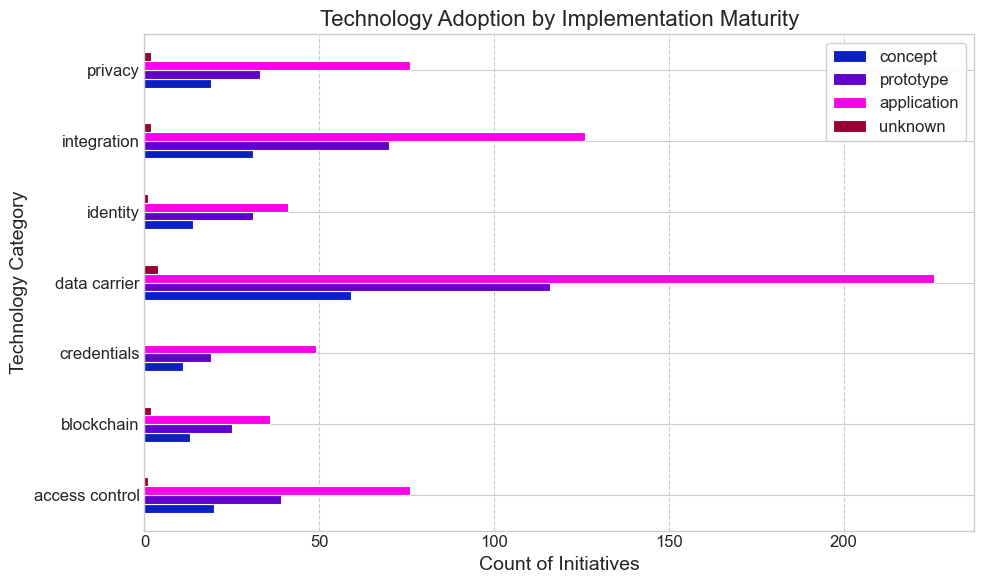

In [76]:
# Now analyze which technologies are most prevalent in different implementation stages
tech_by_readiness = {}

# Make sure we have processed the columns first
for column in text_columns:
    if column not in tech_df.columns or tech_df[column].dtype != 'object':
        tech_df[column] = df_cleaned[column].apply(categorize_technology_text)
    
for column in list_columns:
    if column not in tech_df.columns:
        tech_df[column] = df_cleaned[column].apply(categorize_list_tech)

# Get all unique technology readiness levels
readiness_levels = df_cleaned.explode('Technology_Readiness')['Technology_Readiness'].dropna().unique()

for level in readiness_levels:
    # Get initiatives at this readiness level
    level_df = df_cleaned[df_cleaned['Technology_Readiness'].apply(
        lambda x: level in x if isinstance(x, list) else False)]
    
    # Get corresponding tech categorizations for these initiatives
    level_tech_df = tech_df.loc[level_df.index]
    
    # Count technologies used across all columns for this readiness level
    level_techs = []
    for col in tech_columns:
        # Extract technologies from this column across all initiatives at this level
        for techs in level_tech_df[col]:
            if isinstance(techs, list) and techs:
                level_techs.extend(techs)
    
    # Store counts for this readiness level
    tech_by_readiness[level] = Counter(level_techs)

# Create DataFrame for visualization
tech_readiness_df = pd.DataFrame(index=unique_techs)

for level, counts in tech_by_readiness.items():
    tech_readiness_df[level] = pd.Series(counts)

# Fill NaN with 0 and select only levels with sufficient data
tech_readiness_df = tech_readiness_df.fillna(0)

# Filter to only include technology categories that appear at least once
tech_readiness_df = tech_readiness_df.loc[tech_readiness_df.sum(axis=1) > 0]

# Filter columns to only include readiness levels with enough data
tech_readiness_df = tech_readiness_df.loc[:, tech_readiness_df.sum() >= 2]

# Plot technology adoption by readiness level
plot_multi_bar(
    tech_readiness_df,
    "Technology Adoption by Implementation Maturity",
    xlabel="Count of Initiatives",
    ylabel="Technology Category",
    figsize=(12, 8),
    stacked=False,
    horizontal=True
)

In [ ]:
# Define a comprehensive technology taxonomy
dpp_technology_taxonomy = {
    # Physical identifiers - split into sub-categories for more precision
    'qr_code': ['qr code', 'qr-code', 'quick response code'],
    'rfid': ['rfid', 'radio frequency identification', 'radio-frequency'],
    'nfc': ['nfc', 'near field communication', 'near-field'],
    'digital_watermark': ['digital watermark', 'watermark', 'watermarking'],
    'physical_tag': ['tag', 'tagging', 'physical tag', 'label', 'sticker'],
    'barcode': ['barcode', 'bar code', 'bar-code', 'upc', 'ean'],
    'bluetooth': ['bluetooth', 'ble', 'bluetooth low energy'],
    
    # Blockchain and distributed ledger technologies
    'blockchain': ['blockchain', 'distributed ledger', 'dlt'],
    'smart_contract': ['smart contract', 'smart-contract'],
    'token': ['token', 'nft', 'non-fungible token', 'fungible token'],
    
    # Data architecture approaches
    'centralized_storage': ['centralized', 'central database', 'central storage'],
    'decentralized_storage': ['decentralized', 'distributed storage', 'distributed database'],
    'cloud_storage': ['cloud', 'cloud storage', 'cloud-based'],
    'edge_computing': ['edge', 'edge computing', 'edge storage'],
    
    # Data transfer and APIs
    'api': ['api', 'application programming interface', 'rest', 'graphql'],
    'data_port': ['data port', 'data ports', 'port'],
    'data_transfer': ['data transfer', 'transfer protocol', 'data exchange'],
    'data_space': ['data space', 'dataspace', 'gaia-x'],
    
    # Authentication and identity
    'wallet': ['wallet', 'digital wallet', 'mobile wallet'],
    'ssi': ['ssi', 'self-sovereign', 'self sovereign identity'],
    'digital_identity': ['digital identity', 'digital id', 'e-identity'],
    'verifiable_credential': ['verifiable credential', 'credential', 'vc'],
    
    # Security technologies
    'encryption': ['encryption', 'encrypted', 'encrypt', 'cryptography'],
    'anonymization': ['anonymization', 'anonymized', 'anonymous'],
    'privacy_tech': ['pets', 'privacy enhancing', 'privacy tech', 'privacy-preserving'],
    
    # Access control methods
    'role_based_access': ['role based', 'role-based', 'rbac'],
    'attribute_based_access': ['attribute based', 'attribute-based', 'abac'],
    'access_control': ['access control', 'authorization', 'permission management'],
    
    # Standards and interoperability
    'data_standard': ['standard', 'standards', 'standardization', 'iso'],
    'interoperability': ['interop', 'interoperability', 'interoperable'],
    'data_schema': ['schema', 'data schema', 'json schema', 'xml schema'],
    
    # DPP specific approaches
    'circular_metrics': ['circular', 'circularity', 'circular economy'],
    'product_passport': ['passport', 'product passport', 'digital passport'],
    'compliance_tech': ['compliance', 'regulatory', 'regulation', 'epr'],
    
    # Evidence and traceability
    'traceability': ['traceability', 'traceable', 'trace', 'tracking'],
    'supply_chain': ['supply chain', 'supply-chain', 'value chain'],
    'certification': ['certification', 'certificate', 'certify'],
    
    # Data packaging and formats
    'json_data': ['json', 'json-ld', 'jsonld'],
    'semantic_web': ['rdf', 'owl', 'semantic web', 'linked data'],
    'epcis': ['epcis', 'gs1', 'electronic product code']
}

# Create higher-level categories mapping for visualization
technology_category_groups = {
    'qr_code': 'Physical Identifiers',
    'rfid': 'Physical Identifiers',
    'nfc': 'Physical Identifiers',
    'digital_watermark': 'Physical Identifiers',
    'physical_tag': 'Physical Identifiers',
    'barcode': 'Physical Identifiers',
    'bluetooth': 'Physical Identifiers',
    
    'blockchain': 'Distributed Systems',
    'smart_contract': 'Distributed Systems',
    'token': 'Distributed Systems',
    
    'centralized_storage': 'Data Architecture',
    'decentralized_storage': 'Data Architecture',
    'cloud_storage': 'Data Architecture',
    'edge_computing': 'Data Architecture',
    
    'api': 'Data Exchange',
    'data_port': 'Data Exchange',
    'data_transfer': 'Data Exchange',
    'data_space': 'Data Exchange',
    
    'wallet': 'Identity & Auth',
    'ssi': 'Identity & Auth',
    'digital_identity': 'Identity & Auth',
    'verifiable_credential': 'Identity & Auth',
    
    'encryption': 'Security',
    'anonymization': 'Security',
    'privacy_tech': 'Security',
    
    'role_based_access': 'Access Control',
    'attribute_based_access': 'Access Control',
    'access_control': 'Access Control',
    
    'data_standard': 'Standards',
    'interoperability': 'Standards',
    'data_schema': 'Standards',
    
    'circular_metrics': 'DPP Specific',
    'product_passport': 'DPP Specific',
    'compliance_tech': 'DPP Specific',
    
    'traceability': 'Traceability',
    'supply_chain': 'Traceability',
    'certification': 'Traceability',
    
    'json_data': 'Data Formats',
    'semantic_web': 'Data Formats',
    'epcis': 'Data Formats'
}

# Create a color mapping for each high-level category
category_colors = {
    'Physical Identifiers': thesis_colors['bright_blue'],
    'Distributed Systems': '#E63946',  # Red
    'Data Architecture': '#2A9D8F',    # Teal
    'Data Exchange': '#F4A261',        # Orange
    'Identity & Auth': '#457B9D',      # Blue-grey
    'Security': '#6A0DAD',             # Purple
    'Access Control': '#FCA311',       # Gold
    'Standards': '#4D908E',            # Dark teal
    'DPP Specific': '#277DA1',         # Blue
    'Traceability': '#F94144',         # Coral
    'Data Formats': '#43AA8B'          # Green
}

# Function to detect technologies in text fields
def detect_technologies(text, taxonomy=dpp_technology_taxonomy):
    """
    Detect technologies mentioned in a text field using comprehensive pattern matching.
    Returns a list of technology identifiers found in the text.
    """
    if not isinstance(text, str):
        return []
    
    text = text.lower()
    found_techs = []
    
    for tech_id, keywords in taxonomy.items():
        for keyword in keywords:
            # Check for whole word or phrase matches to avoid false positives
            if re.search(r'\b' + re.escape(keyword) + r'\b', text):
                found_techs.append(tech_id)
                break  # Once we've found one keyword for this tech, no need to check others
    
    return found_techs

# Function to detect technologies in list fields
def detect_technologies_in_list(items_list, taxonomy=dpp_technology_taxonomy):
    """
    Detect technologies mentioned in a list of text items.
    Returns a list of technology identifiers found in any of the list items.
    """
    if not isinstance(items_list, list):
        return []
    
    found_techs = []
    
    for item in items_list:
        if not isinstance(item, str):
            continue
        
        item_techs = detect_technologies(item, taxonomy)
        found_techs.extend(item_techs)
    
    return list(set(found_techs))  # Remove duplicates

# Apply technology detection to relevant fields
def extract_all_technologies(row):
    """
    Extract all technologies mentioned across multiple fields in a row.
    Handle both text fields and list fields appropriately.
    """
    all_techs = []
    
    # Text fields to check
    text_fields = [
        'Evidence', 'Data_Transport_Openness_Level', 'Data_Use_Management',
        'Data_Protection', 'Data_Packaging', 'Data_Storage_Location', 'ID_Minting',
        'Convenience'
    ]
    
    # List fields to check
    list_fields = [
        'Identifier_Type', 'Traceability'
    ]
    
    # Process text fields
    for field in text_fields:
        if field in row and isinstance(row[field], str):
            techs = detect_technologies(row[field])
            all_techs.extend(techs)
    
    # Process list fields
    for field in list_fields:
        if field in row and isinstance(row[field], list):
            techs = detect_technologies_in_list(row[field])
            all_techs.extend(techs)
    
    return list(set(all_techs))  # Remove duplicates

Detected Technologies (Count):
qr_code (Physical Identifiers): 160
physical_tag (Physical Identifiers): 150
api (Data Exchange): 114
decentralized_storage (Data Architecture): 113
rfid (Physical Identifiers): 107
centralized_storage (Data Architecture): 102
nfc (Physical Identifiers): 92
anonymization (Security): 84
role_based_access (Access Control): 81
blockchain (Distributed Systems): 66
data_transfer (Data Exchange): 56
wallet (Identity & Auth): 54
digital_watermark (Physical Identifiers): 52
privacy_tech (Security): 46
bluetooth (Physical Identifiers): 32
data_port (Data Exchange): 32
encryption (Security): 5
data_standard (Standards): 5
supply_chain (Traceability): 3
traceability (Traceability): 3
access_control (Access Control): 3
cloud_storage (Data Architecture): 2
smart_contract (Distributed Systems): 2
digital_identity (Identity & Auth): 2
token (Distributed Systems): 2
interoperability (Standards): 2
compliance_tech (DPP Specific): 2
data_schema (Standards): 1
epcis (Data F

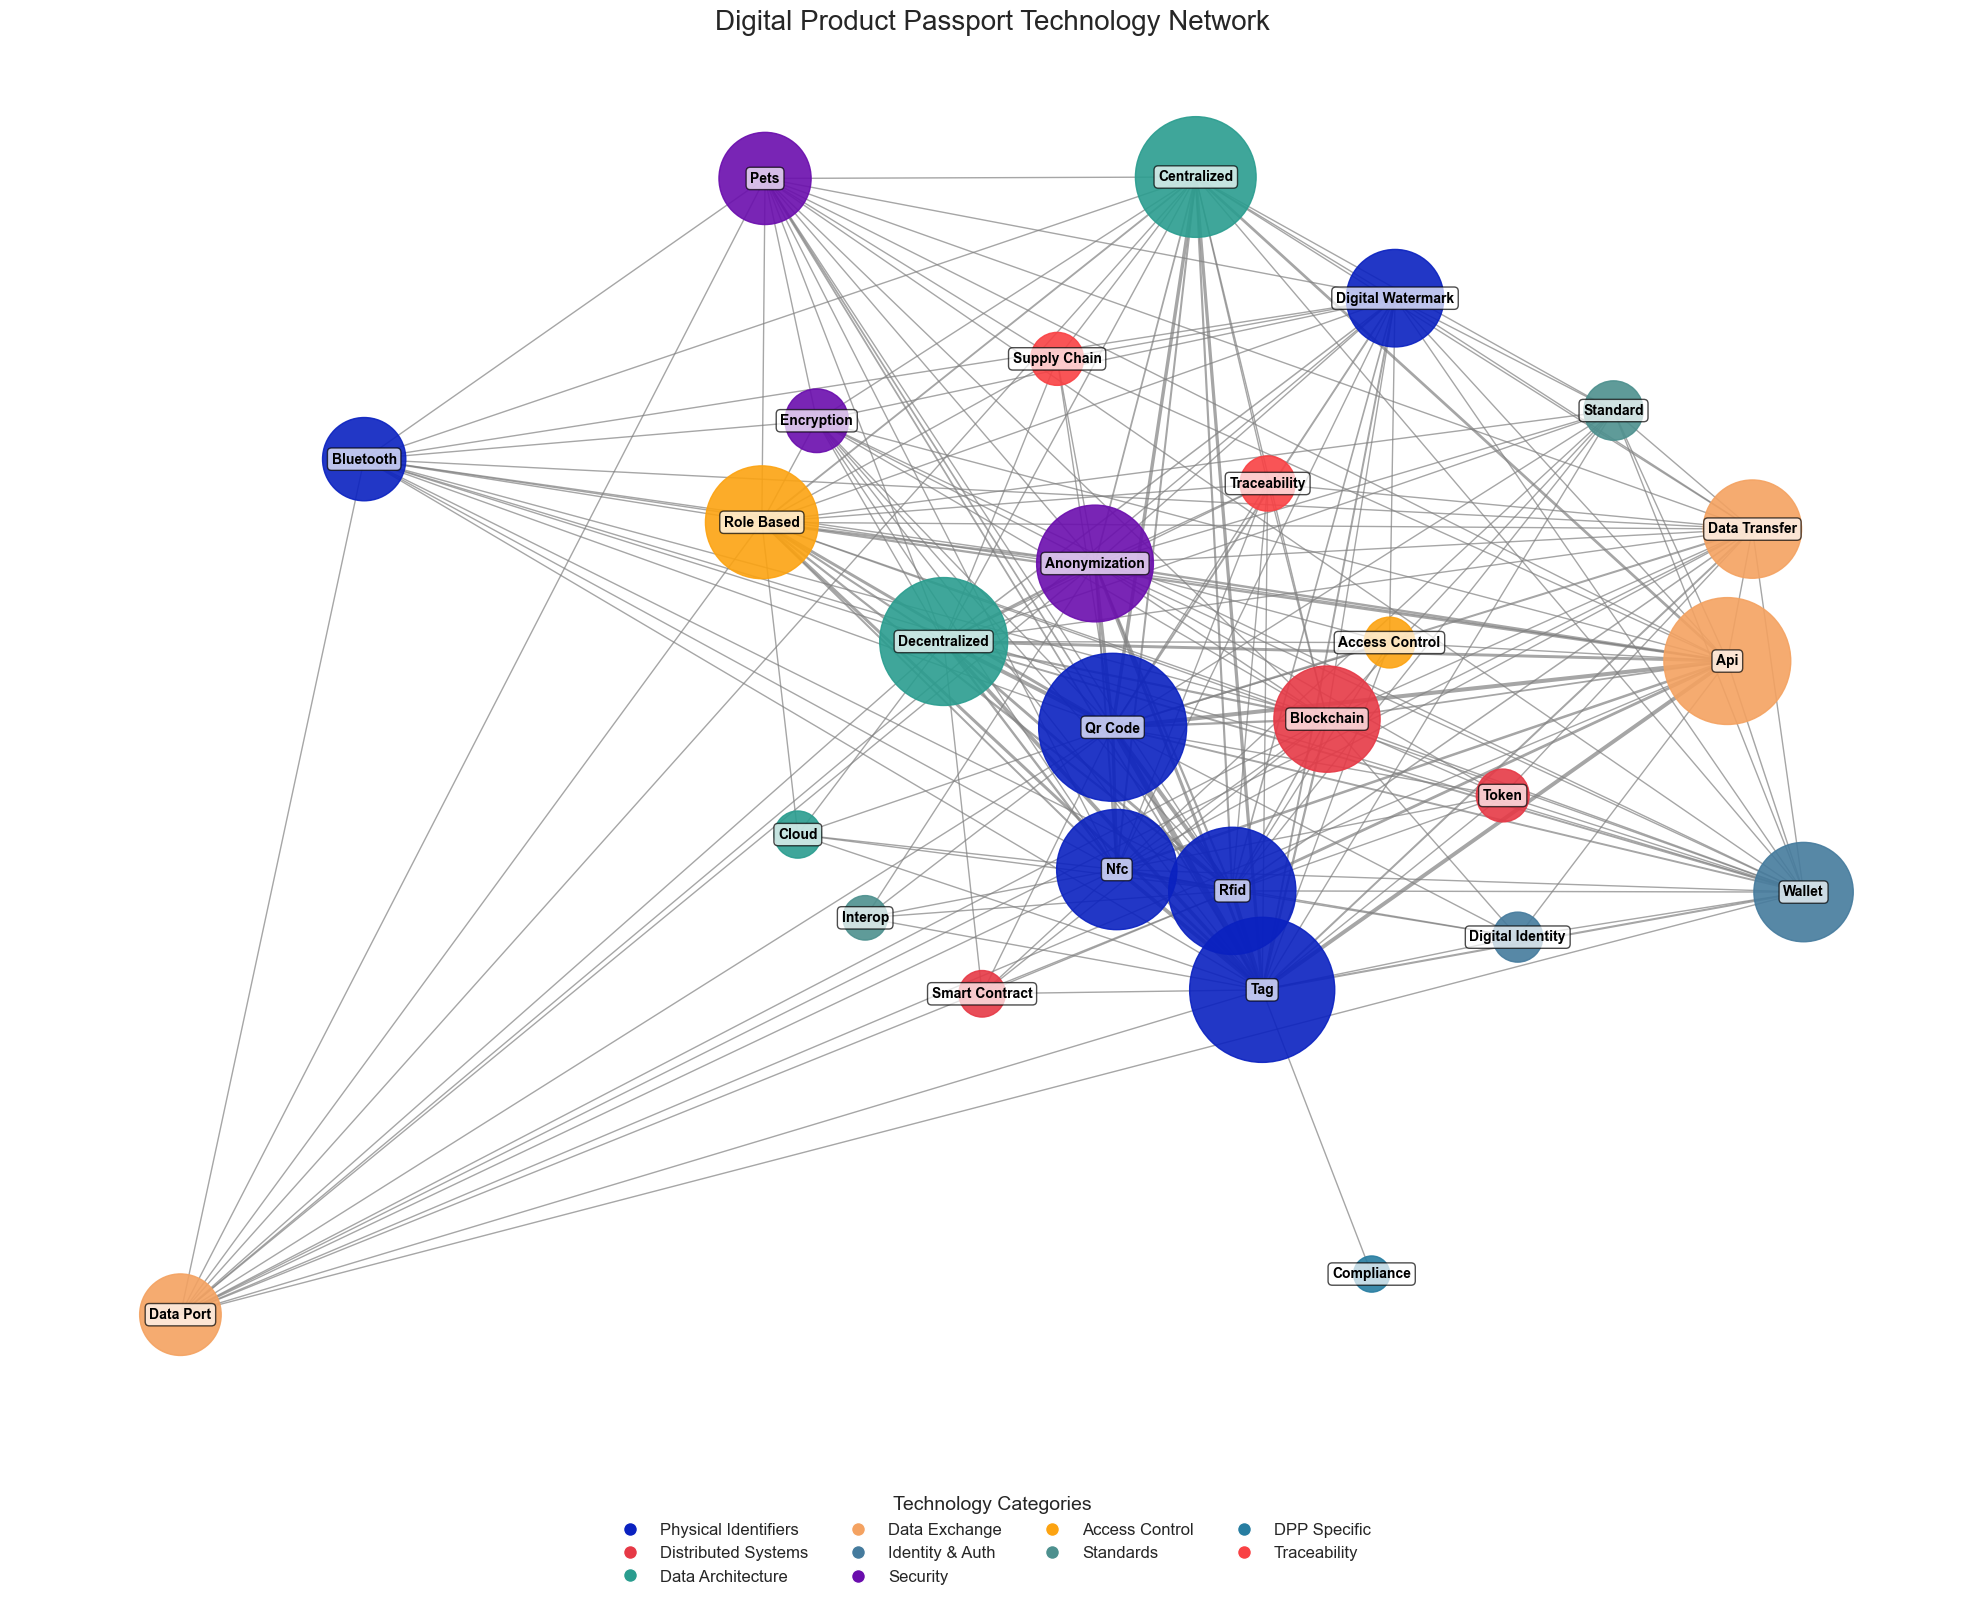


--- KEY INSIGHTS ABOUT THE DPP TECHNOLOGY LANDSCAPE ---

Most Central Technologies (By Betweenness Centrality):
encryption (Security): 0.119 - 5 occurrences
token (Distributed Systems): 0.110 - 2 occurrences
tag (Physical Identifiers): 0.109 - 150 occurrences
anonymization (Security): 0.088 - 84 occurrences
supply chain (Traceability): 0.088 - 3 occurrences
qr code (Physical Identifiers): 0.078 - 160 occurrences
digital identity (Identity & Auth): 0.074 - 2 occurrences
traceability (Traceability): 0.071 - 3 occurrences
access control (Access Control): 0.069 - 3 occurrences
wallet (Identity & Auth): 0.059 - 54 occurrences

Most Connected Technologies (By Degree):
qr code (Physical Identifiers): 25 connections - 160 occurrences
tag (Physical Identifiers): 25 connections - 150 occurrences
rfid (Physical Identifiers): 24 connections - 107 occurrences
nfc (Physical Identifiers): 23 connections - 92 occurrences
decentralized (Data Architecture): 22 connections - 113 occurrences
anonymizatio

In [ ]:
import networkx as nx

# Apply the improved technology detection across the dataset
df_tech_enriched = df_cleaned.copy()
df_tech_enriched['technologies'] = df_tech_enriched.apply(extract_all_technologies, axis=1)

# Get all detected technologies and their frequencies
all_detected_techs = []
for techs in df_tech_enriched['technologies']:
    if isinstance(techs, list):
        all_detected_techs.extend(techs)

tech_counts = Counter(all_detected_techs)
print("Detected Technologies (Count):")
for tech, count in tech_counts.most_common():
    category = technology_category_groups.get(tech, "Other")
    print(f"{tech} ({category}): {count}")

# Create co-occurrence matrix for network analysis
tech_ids = [tech for tech, count in tech_counts.items() if count >= 2]  # Only include technologies that appear at least twice
tech_cooccurrence = pd.DataFrame(0, index=tech_ids, columns=tech_ids)

# Fill the co-occurrence matrix
for _, row in df_tech_enriched.iterrows():
    techs = row['technologies']
    if not isinstance(techs, list) or len(techs) < 2:
        continue
        
    # Only use technologies that meet our minimum frequency threshold
    techs = [t for t in techs if t in tech_ids]
    
    # Count co-occurrences
    for i, tech1 in enumerate(techs):
        for tech2 in techs[i+1:]:  # Only check pairs once
            tech_cooccurrence.loc[tech1, tech2] += 1
            tech_cooccurrence.loc[tech2, tech1] += 1  # Symmetric matrix

# Create the network graph
G = nx.Graph()

# Add nodes with their categories and colors
for tech_id in tech_ids:
    category = technology_category_groups.get(tech_id, "Other")
    color = category_colors.get(category, thesis_colors['light_grey'])
    # Get the readable name for the technology (first keyword in the taxonomy)
    readable_name = dpp_technology_taxonomy.get(tech_id, [tech_id])[0]
    
    G.add_node(tech_id, 
               category=category,
               color=color,
               count=tech_counts[tech_id],
               label=readable_name)

# Add edges with significant weights
for i, tech1 in enumerate(tech_ids):
    for tech2 in tech_ids[i+1:]:
        weight = tech_cooccurrence.loc[tech1, tech2]
        if weight > 1:  # Only include meaningful relationships
            G.add_edge(tech1, tech2, weight=weight)

# Calculate node importance metrics
degree = dict(nx.degree_centrality(G))
betweenness = nx.betweenness_centrality(G, weight='weight')
eigenvector = nx.eigenvector_centrality_numpy(G, weight='weight')

# Scale node sizes based on frequency and importance
node_sizes = {}
for node in G.nodes():
    # Combine multiple metrics for node sizing
    base_size = 500
    count_factor = tech_counts[node] * 50
    centrality_factor = (degree[node] + betweenness[node] + eigenvector[node]) * 2000
    
    node_sizes[node] = base_size + count_factor + centrality_factor

# Prepare for visualization
plt.figure(figsize=(20, 16))

# Use a layout for the network structure
# pos = nx.spring_layout(G, k=0.8, iterations=200, seed=42, scale=2.0)
pos = nx.kamada_kawai_layout(G, scale=2.0)


# Get node properties for drawing
node_colors = [G.nodes[n]['color'] for n in G.nodes()]
node_size_values = [node_sizes[n] for n in G.nodes()]

# Get edge weights for drawing
edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
max_edge_weight = max(edge_weights) if edge_weights else 1
normalized_edge_weights = [max(1, 4 * w / max_edge_weight) for w in edge_weights]

# Draw the network with improved visual clarity
nx.draw_networkx_nodes(G, pos, 
                      node_color=node_colors,
                      node_size=node_size_values, 
                      alpha=0.9)

# Draw edges with transparency based on weight
edge_colors = [(0.5, 0.5, 0.5, min(0.8, w/(2*max_edge_weight) + 0.2)) for w in edge_weights]
nx.draw_networkx_edges(G, pos, 
                      width=normalized_edge_weights,
                      edge_color=edge_colors,
                      alpha=0.7)

# Create more readable labels with proper capitalization
labels = {node: G.nodes[node]['label'].title() for node in G.nodes()}
nx.draw_networkx_labels(G, pos, 
                       labels=labels,
                       font_size=10, 
                       font_weight='bold',
                       font_color='black',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

# Add a legend for the technology categories
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                             markersize=10, label=category)
                  for category, color in category_colors.items() 
                  if any(technology_category_groups.get(n) == category for n in G.nodes())]

# Create a positioned legend outside the main plot area
plt.legend(handles=legend_elements, 
          loc='lower center', 
          bbox_to_anchor=(0.5, -0.12),
          ncol=4,
          title="Technology Categories",
          fontsize=12,
          title_fontsize=14)

plt.title("Digital Product Passport Technology Network", fontsize=20, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print key insights about the technology landscape
print("\n--- KEY INSIGHTS ABOUT THE DPP TECHNOLOGY LANDSCAPE ---")

print("\nMost Central Technologies (By Betweenness Centrality):")
for tech, score in sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]:
    category = G.nodes[tech]['category']
    label = G.nodes[tech]['label']
    print(f"{label} ({category}): {score:.3f} - {tech_counts[tech]} occurrences")

print("\nMost Connected Technologies (By Degree):")
for tech, score in sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]:
    category = G.nodes[tech]['category']
    label = G.nodes[tech]['label']
    connections = len(list(G.neighbors(tech)))
    print(f"{label} ({category}): {connections} connections - {tech_counts[tech]} occurrences")

print("\nMost Common Technology Pairs:")
for u, v, data in sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:15]:
    cat_u = G.nodes[u]['category']
    cat_v = G.nodes[v]['category']
    label_u = G.nodes[u]['label']
    label_v = G.nodes[v]['label']
    print(f"{label_u} ({cat_u}) + {label_v} ({cat_v}): {data['weight']} co-occurrences")

# Compare technology adoption across readiness levels
print("\nTechnology Adoption by Readiness Level:")
readiness_tech_counts = {}

for readiness in ['concept', 'prototype', 'application']:
    # Get initiatives at this readiness level
    initiatives = df_tech_enriched[df_tech_enriched['Technology_Readiness'].apply(
        lambda x: readiness in x if isinstance(x, list) else False)]
    
    # Count technology occurrences
    techs = []
    for tech_list in initiatives['technologies']:
        if isinstance(tech_list, list):
            techs.extend(tech_list)
    
    # Store counts by category (for higher-level insights)
    category_counts = {}
    for tech in techs:
        category = technology_category_groups.get(tech, "Other")
        category_counts[category] = category_counts.get(category, 0) + 1
    
    readiness_tech_counts[readiness] = category_counts
    
    print(f"\n{readiness.capitalize()} stage - Top 5 technology categories:")
    for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {category}: {count}")


--- TECHNOLOGY CLUSTERING ANALYSIS ---

Method 1: Network-based technology communities

Technology Community 1:
  pets (Security)
  token (Distributed Systems)
  traceability (Traceability)
  encryption (Security)
  anonymization (Security)
  data transfer (Data Exchange)
  digital watermark (Physical Identifiers)
  nfc (Physical Identifiers)
  smart contract (Distributed Systems)
  cloud (Data Architecture)
  standard (Standards)
  bluetooth (Physical Identifiers)
  data port (Data Exchange)
  digital identity (Identity & Auth)
  centralized (Data Architecture)
  qr code (Physical Identifiers)
  tag (Physical Identifiers)
  access control (Access Control)
  wallet (Identity & Auth)
  interop (Standards)
  decentralized (Data Architecture)
  role based (Access Control)
  api (Data Exchange)
  supply chain (Traceability)
  compliance (DPP Specific)
  blockchain (Distributed Systems)
  rfid (Physical Identifiers)

Method 2: Feature-based technology clusters


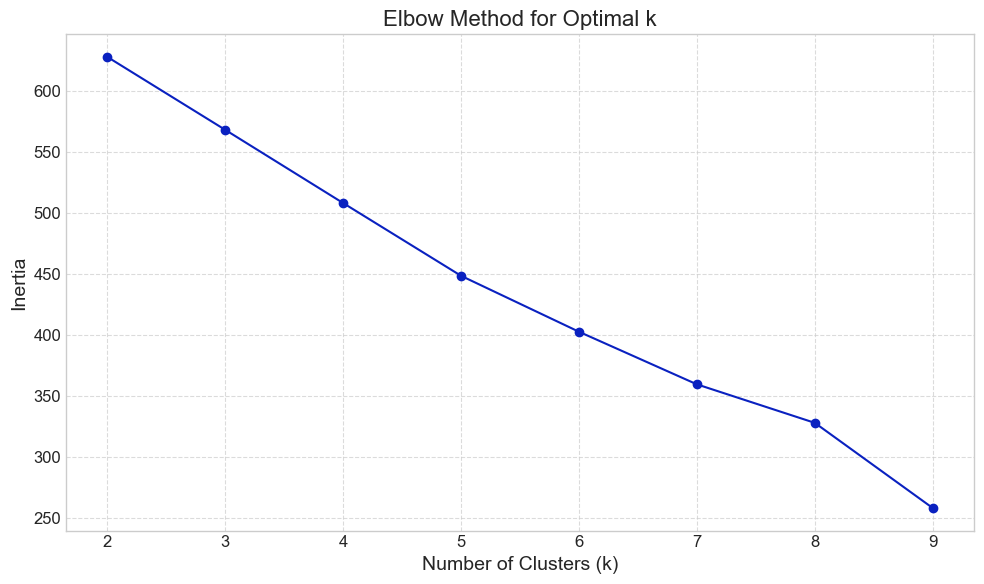


Technology Cluster 1:
  pets (Security)
  wallet (Identity & Auth)
  digital watermark (Physical Identifiers)
  supply chain (Traceability)
  blockchain (Distributed Systems)
  encryption (Security)
  data transfer (Data Exchange)
  bluetooth (Physical Identifiers)
  cloud (Data Architecture)
  data port (Data Exchange)
  smart contract (Distributed Systems)
  digital identity (Identity & Auth)
  token (Distributed Systems)
  interop (Standards)
  standard (Standards)
  traceability (Traceability)
  compliance (DPP Specific)
  access control (Access Control)

Technology Cluster 3:
  centralized (Data Architecture)

Technology Cluster 2:
  decentralized (Data Architecture)
  api (Data Exchange)
  qr code (Physical Identifiers)
  tag (Physical Identifiers)

Technology Cluster 4:
  role based (Access Control)
  rfid (Physical Identifiers)
  anonymization (Security)
  nfc (Physical Identifiers)


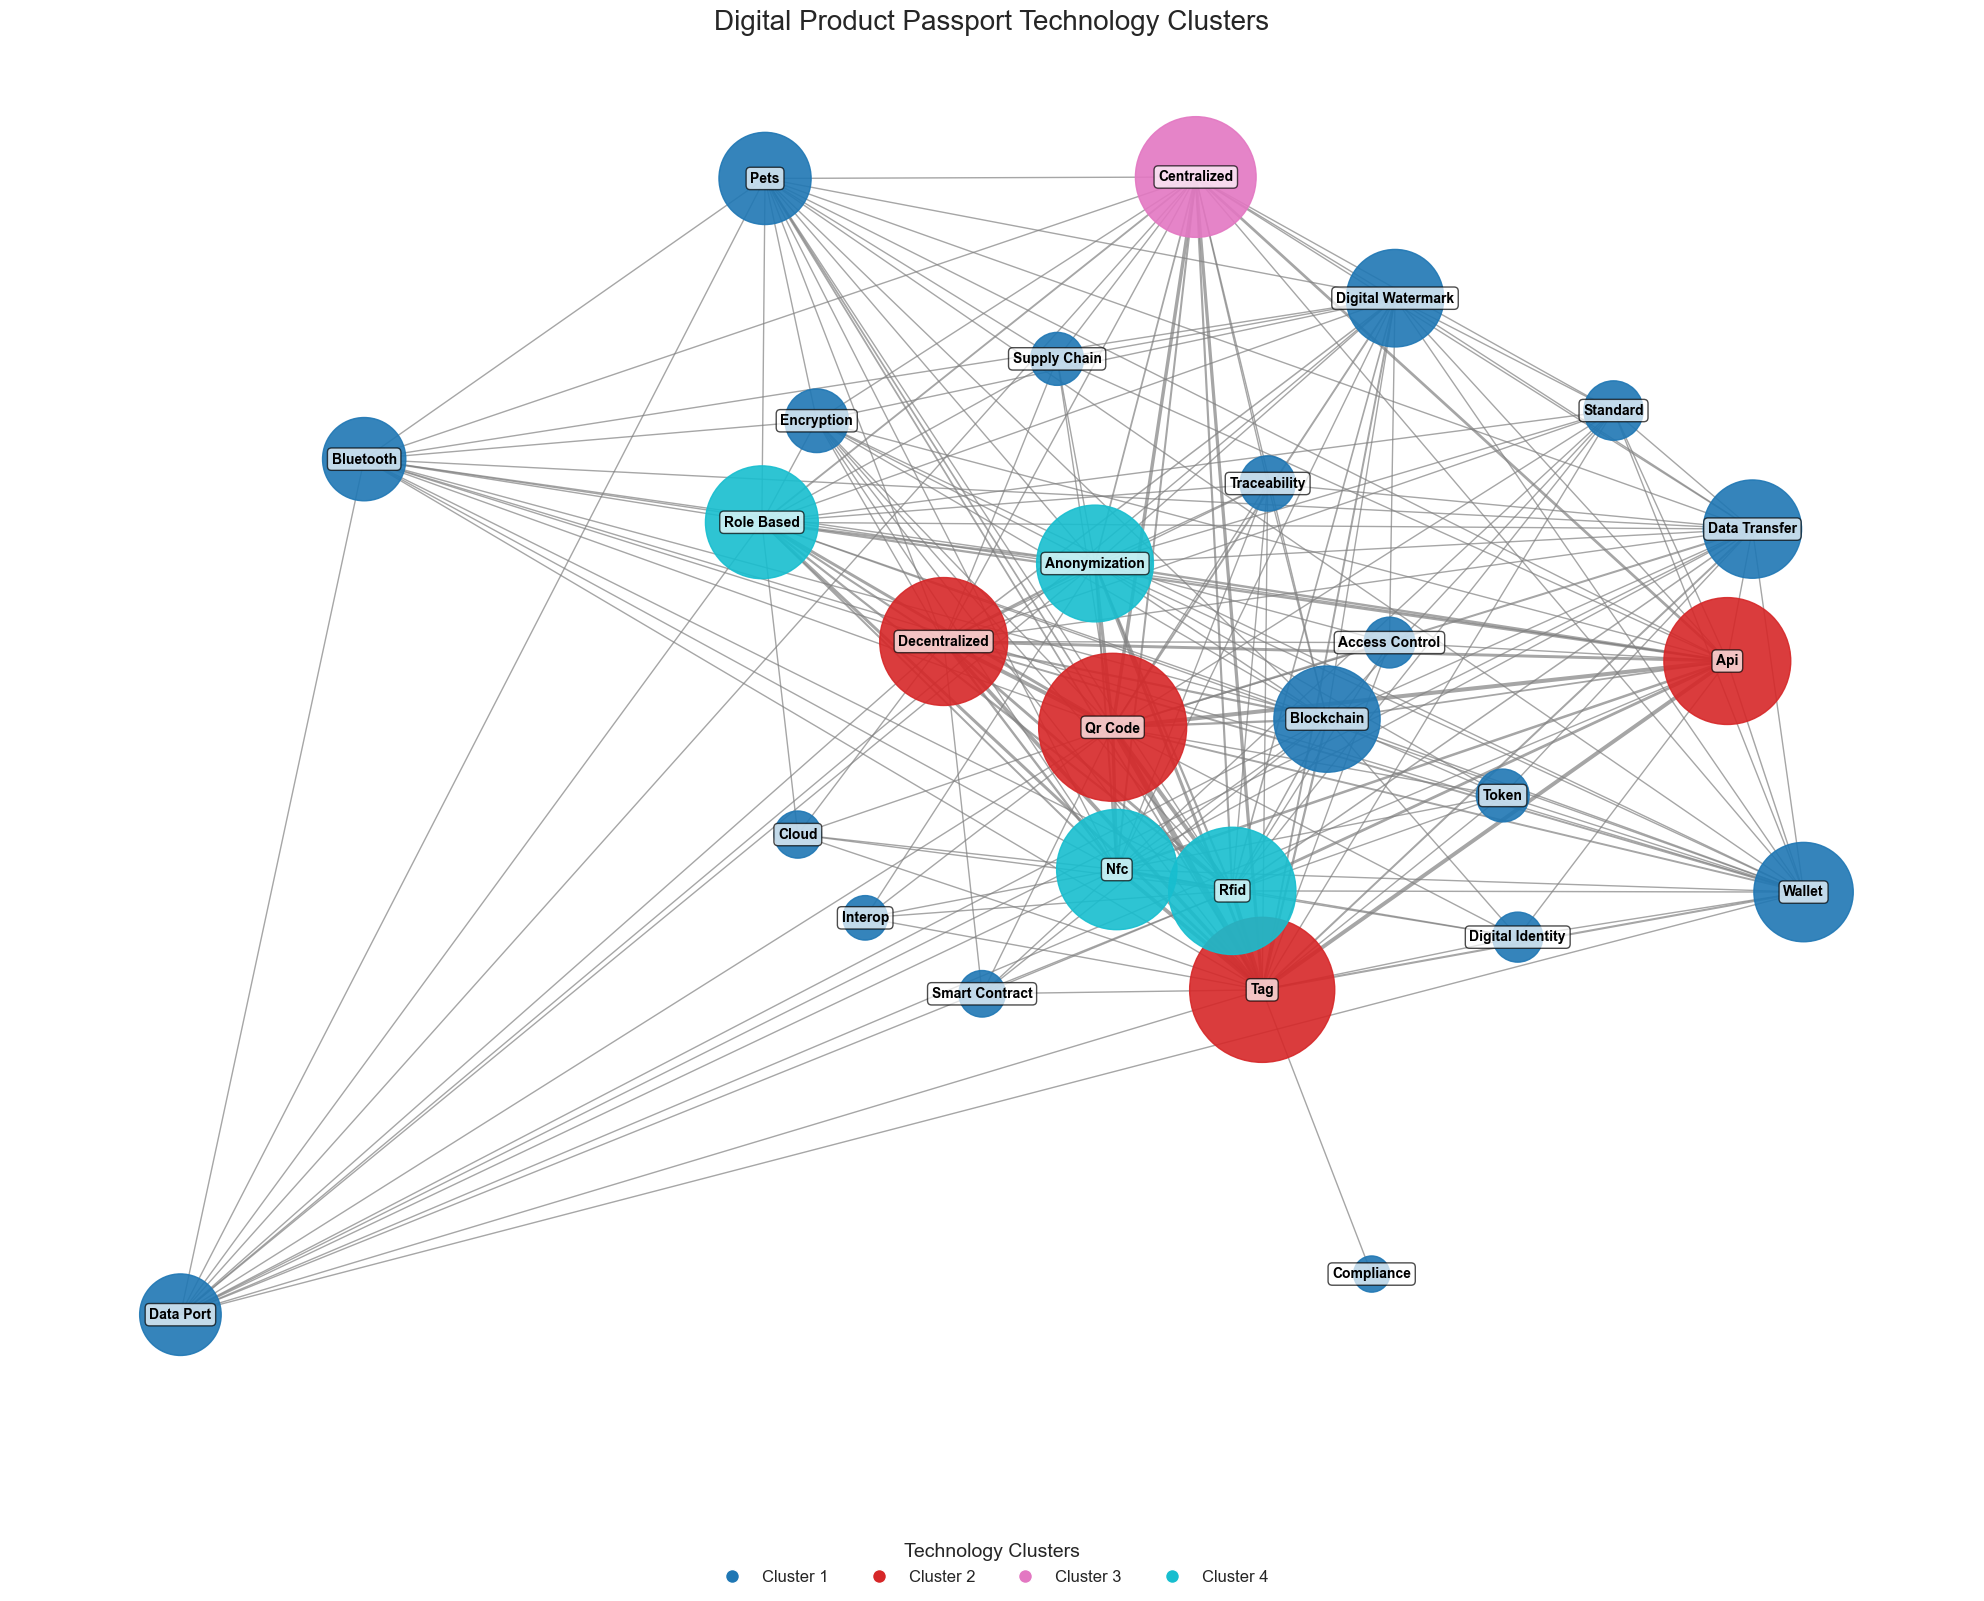


Cluster distribution across technology readiness levels:


<Figure size 1200x800 with 0 Axes>

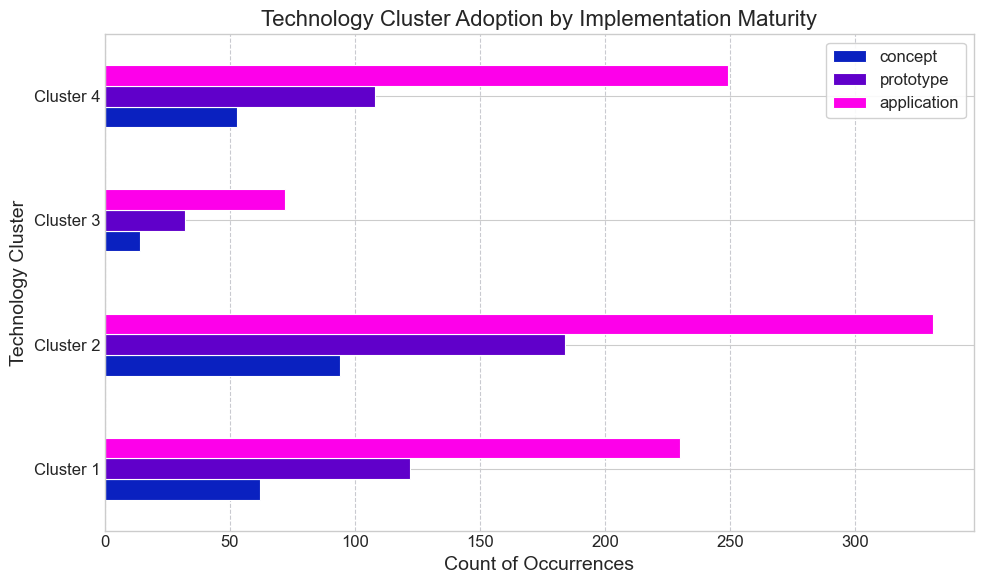

In [ ]:
# Add technology clustering to identify related technology communities
import networkx.algorithms.community as nx_comm
from sklearn.cluster import KMeans

# Method 1: Network-based clustering (detect communities in the technology network)
# This identifies technologies that frequently appear together
print("\n--- TECHNOLOGY CLUSTERING ANALYSIS ---")
print("\nMethod 1: Network-based technology communities")

# Apply the Louvain community detection algorithm
communities = nx_comm.louvain_communities(G, weight='weight', resolution=1.0)

# Print the communities
for i, community in enumerate(communities):
    if len(community) > 1:  # Only show communities with multiple technologies
        print(f"\nTechnology Community {i+1}:")
        for tech_id in community:
            category = technology_category_groups.get(tech_id, "Other")
            label = G.nodes[tech_id]['label']
            print(f"  {label} ({category})")

# Method 2: Feature-based clustering (based on where technologies appear)
print("\nMethod 2: Feature-based technology clusters")

# Create a presence matrix: rows = technologies, columns = initiatives
tech_initiative_matrix = np.zeros((len(tech_ids), len(df_tech_enriched)))

# Fill the matrix with binary values (1 = technology appears in initiative)
for i, tech_id in enumerate(tech_ids):
    for j, techs in enumerate(df_tech_enriched['technologies']):
        if isinstance(techs, list) and tech_id in techs:
            tech_initiative_matrix[i, j] = 1

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(2, min(10, len(tech_ids)))
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tech_initiative_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-', color=thesis_colors['bright_blue'])
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Choose a reasonable number of clusters (automatically or manually)
# Look for the "elbow" in the plot, or use a heuristic
k_optimal = 4  # You can adjust this after seeing the elbow plot

# Apply K-means clustering
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(tech_initiative_matrix)

# Create a dictionary to store technologies by cluster
tech_clusters = {}
for i, cluster_id in enumerate(clusters):
    if cluster_id not in tech_clusters:
        tech_clusters[cluster_id] = []
    tech_id = tech_ids[i]
    tech_clusters[cluster_id].append(tech_id)

# Print the clusters
for cluster_id, cluster_techs in tech_clusters.items():
    print(f"\nTechnology Cluster {cluster_id+1}:")
    for tech_id in cluster_techs:
        category = technology_category_groups.get(tech_id, "Other")
        label = G.nodes[tech_id]['label']
        print(f"  {label} ({category})")

# Visualize the clusters on the network graph
plt.figure(figsize=(20, 16))

# Use the same layout as before for consistency
# pos = nx.spring_layout(G, k=0.8, iterations=200, seed=42, scale=2.0)

# Create a dictionary mapping tech_id to cluster_id
tech_to_cluster = {tech_ids[i]: clusters[i] for i in range(len(tech_ids))}

# Create a colormap for the clusters
cluster_colors = plt.cm.tab10(np.linspace(0, 1, k_optimal))

# Get node colors based on clusters
node_cluster_colors = [cluster_colors[tech_to_cluster.get(node, 0)] for node in G.nodes()]

# Draw the network with cluster colors
nx.draw_networkx_nodes(G, pos, 
                     node_color=node_cluster_colors,
                     node_size=node_size_values, 
                     alpha=0.9)

# Draw edges
nx.draw_networkx_edges(G, pos, 
                      width=normalized_edge_weights,
                      edge_color=edge_colors,
                      alpha=0.7)

# Add labels
nx.draw_networkx_labels(G, pos, 
                      labels=labels,
                      font_size=10, 
                      font_weight='bold',
                      font_color='black',
                      bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

# Create legend for clusters
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=cluster_colors[i], 
                             markersize=10, 
                             label=f'Cluster {i+1}')
                  for i in range(k_optimal)]

plt.legend(handles=legend_elements, 
          loc='lower center', 
          bbox_to_anchor=(0.5, -0.12),
          ncol=5,
          title="Technology Clusters",
          fontsize=12,
          title_fontsize=14)

plt.title("Digital Product Passport Technology Clusters", fontsize=20, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Analyze the relationship between clusters and technology readiness
# This helps understand which technology groups appear at different maturity levels
print("\nCluster distribution across technology readiness levels:")

# Create a DataFrame to store the counts
cluster_readiness = pd.DataFrame(0, 
                                index=[f"Cluster {i+1}" for i in range(k_optimal)],
                                columns=['concept', 'prototype', 'application'])

# Count occurrences of each cluster in each readiness level
for readiness in ['concept', 'prototype', 'application']:
    # Get initiatives at this readiness level
    initiatives = df_tech_enriched[df_tech_enriched['Technology_Readiness'].apply(
        lambda x: readiness in x if isinstance(x, list) else False)]
    
    # For each initiative, check which technologies (and thus clusters) are present
    for _, row in initiatives.iterrows():
        techs = row['technologies']
        if isinstance(techs, list):
            # Find which clusters these technologies belong to
            for tech in techs:
                if tech in tech_to_cluster:
                    cluster_id = tech_to_cluster[tech]
                    cluster_readiness.loc[f"Cluster {cluster_id+1}", readiness] += 1

# Plot the results
plot_multi_bar(
    cluster_readiness,
    "Technology Cluster Adoption by Implementation Maturity",
    xlabel="Count of Occurrences",
    ylabel="Technology Cluster",
    figsize=(12, 8),
    stacked=False,
    horizontal=True
)